In [1]:
import os
os.chdir('/export/sphere/ebirah/ko20929/RBD_files/notebooks/frequency_analysis/')

#Sktime imports
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.utils import io
import pandas as pd
import os
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import seaborn as sns
import time
import joblib
import sys
from os.path import exists

import importlib

#Sklearn static classifier imports for baseline models
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit

#Sklearn metric imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from statsmodels.stats.weightstats import DescrStatsW

#My modules
import run_expts
import constants

In [19]:
#Use N3 data for the Dummy Classifier as it has the most samples ... 73
core_path = 'constructed_data/band_power_time_series/expt_dfs/'
folder = 'N3_full_expts/'

load_path = core_path + folder

X = pd.read_hdf(load_path + 'X.h5', key='df', mode='r')
y = pd.read_hdf(load_path + 'y_full.h5', key='df', mode='r') 
groups = pd.read_hdf(load_path + 'groups.h5', key='df', mode='r')  

mean_results_dict = {}
class_distributions = {}

for i in [1,2,3,4]:

    #Now X, Y and groups have been loaded for N3 data (for dummy models) - generate X,y groups for a specific experiment
    #1.Generate expt specific X,y,groups
    X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(X,y,groups, i )
    X_expt = X_expt[['Delta_Prefrontal', 'Theta_Prefrontal', 'Alpha_Prefrontal']] #Only keep three features for dummy models

    #Three runs for running the expts
    subsets_dict = {'run_1' : ['Delta_Prefrontal'] , 'run_2' : ['Theta_Prefrontal'] , 'run_3' : ['Alpha_Prefrontal'] }

    clfs = {'D_uniform' : DummyClassifier(strategy = 'uniform') , 'D_prior' : DummyClassifier(strategy = 'prior') ,
            'D_stratified' : DummyClassifier(strategy = 'stratified') }

    t1 = time.time()

    results_df = run_expts.run_mv_tsc(X_expt,y_expt,groups_expt, clfs , return_df = True , subset_names_and_cols = subsets_dict, random_states = [1,2] )

    res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)  

    mean_results = res_df[[col for col in res_df.columns if 'acc' in col]].mean(axis = 0) 
    
    expt = 'expt_' + str(i)
    
    class_distributions[expt] = y_expt.value_counts()
    
    mean_results_dict[expt] = mean_results

    t2 = time.time()
    t2 - t1

mean_results_df = pd.concat(mean_results_dict , axis = 1)

<Figure size 640x480 with 0 Axes>

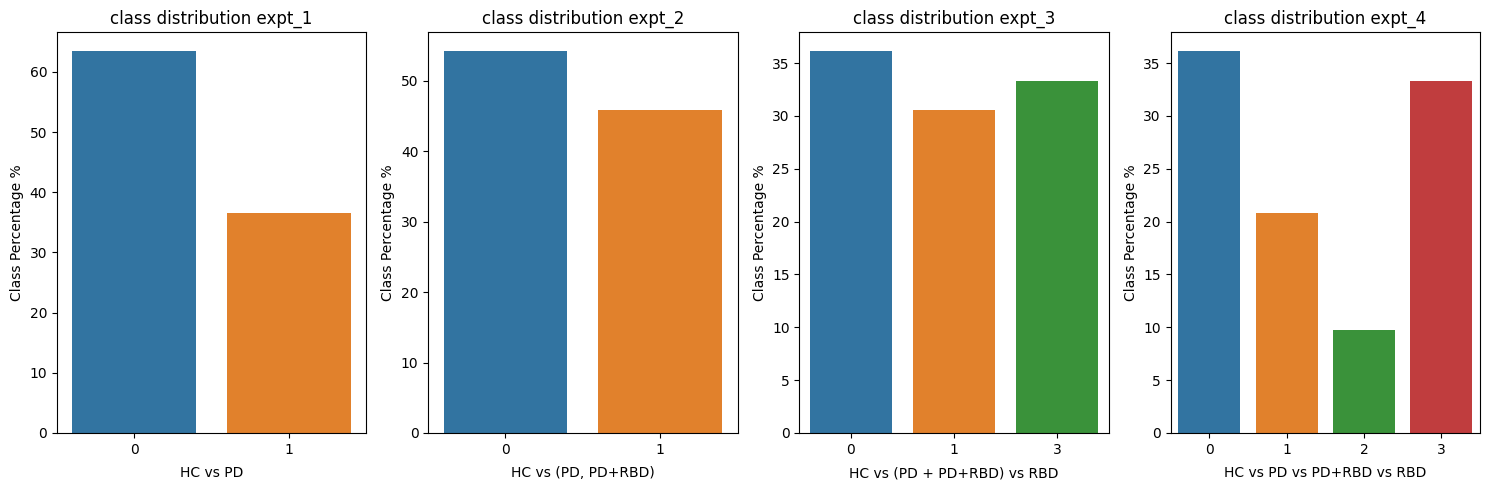

In [40]:
#Do the plots again for data type accuracy distribution
fig = plt.figure()
fig = plt.figure(figsize=(15,5),dpi=100)
captions = ['HC vs PD' , 'HC vs (PD, PD+RBD)' , 'HC vs (PD + PD+RBD) vs RBD' , 'HC vs PD vs PD+RBD vs RBD' ]

for i in [1,2,3,4]:
    expt_num = i
    expt = 'expt_' + str(i)
    
    ax = fig.add_subplot(1,4,i)
    plt.title('class distribution ' + expt)
    #percen tej in each class
    sns.barplot(x = class_distributions[expt].index, y= class_distributions[expt].values*100 / class_distributions[expt].values.sum() )
    plt.text(0.5, -0.1, captions[i-1] , ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.ylabel('Class Percentage %')
    plt.tight_layout()
    
plt.tight_layout()

In [37]:
mean_results_df

,expt_1,expt_2,expt_3,expt_4
run_1_D_uniform_acc,0.486111,0.552222,0.312857,0.264762
run_1_D_prior_acc,0.629167,0.418889,0.258095,0.291429
run_1_D_stratified_acc,0.472222,0.447778,0.280000,0.312381
run_2_D_uniform_acc,0.563889,0.431111,0.360000,0.276667
run_2_D_prior_acc,0.629167,0.418889,0.258095,0.291429
run_2_D_stratified_acc,0.511111,0.464444,0.318095,0.327619
run_3_D_uniform_acc,0.465278,0.507778,0.245238,0.233810
run_3_D_prior_acc,0.629167,0.418889,0.258095,0.291429
run_3_D_stratified_acc,0.519444,0.436667,0.311429,0.285238
